In [1]:
import xarray as xr
from pyproj import Proj
from dask.diagnostics import ProgressBar
import numpy as np
import matplotlib.pyplot as plt
import xesmf as xe
import rioxarray
import cartopy
import cartopy.crs as ccrs
import os, psutil
rivers = cartopy.feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='blue')
land_50m = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])

In [2]:
version = '0.3'

In [3]:
def find_closest_point_0025_grid(latitude, longitude):
    lat_grid = np.arange(0, 90, 0.025)
    lon_grid = np.arange(-180, -40, 0.025)

    diff = np.abs(lat_grid - latitude)
    lat_point_grid = lat_grid[np.where((diff) == np.min(diff))]
    diff = np.abs(lon_grid - longitude)
    lon_point_grid = lon_grid[np.where((diff) == np.min(diff))]
    
    return lat_point_grid, lon_point_grid

def open_elevation_data():
    data = rioxarray.open_rasterio('/data/AIDL-UPC/wc2.1_30s_elev.tif')
    data = data.rename({'x': 'lon','y': 'lat'})
    data = data.assign_coords(lat=-data.lat)
    return data

In [4]:
file = '/data/AIDL-UPC/std_mean_daymet_v4_daily_v0.3.nc'
data_precip_HR = xr.open_dataset(file)


In [5]:
# select lat y lons from the points of interest

file = '/data/AIDL-UPC/daymet_v4_daily/prcp/used/short/daymet_v4_daily_na_prcp_sel50_latlon_Nevada_Utah.nc'
#daymet_v4_daily_na_prcp_sel200_latlon_nonan.nc'
data_latlon = xr.open_dataset(file)


# read mean and std to normalize the high res precip
file = '/data/AIDL-UPC/std_mean_daymet_v4_daily_v0.3.nc'
data_precip_HR = xr.open_dataset(file)
mean_precip_HR = data_precip_HR['mean']
std_precip_HR = data_precip_HR['std']
# read seasonal cycle of the high res precip to remove 
seas_cyc_precip_HR = data_precip_HR.seas_cyc


# read mean and std to normalize the input data
file = '/data/AIDL-UPC/std_mean_variables_ERA5_v'+version+'.nc'
data_mean_std = xr.open_dataset(file)
mean = data_mean_std.mean_all
std = data_mean_std.std_all

# read seasonal cycle to remove
file = '/data/AIDL-UPC/seas_cyc_variables_ERA5_v'+version+'.nc'
data_seas_cyc = xr.open_dataset(file)
seas_cyc = data_seas_cyc.seas_cyc

# read elevation file and land-ocean mask
land_ocean= xr.open_dataset('/data/AIDL-UPC/land_ocean_mask_v'+version+'.nc')

elevation_norm= xr.open_dataset('/data/AIDL-UPC/elevation_norm_v'+version+'.nc')

In [6]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)

290.66796875


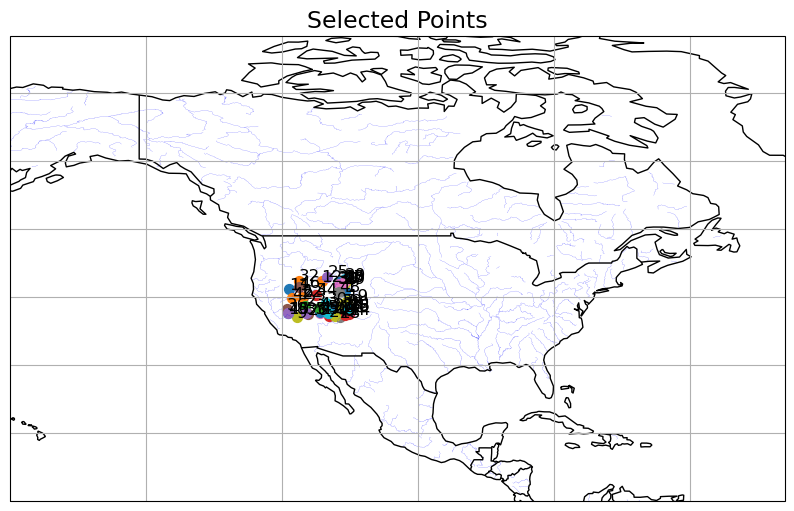

In [7]:
# define number of points to be computed from a random selection of the non-nan points

fig, axes = plt.subplots(ncols=1,nrows = 1, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(10,10))
npoints = 50
axes.set_title('Selected Points', fontsize = 17 )   

icount_point = 1
for ipoint in range(npoints):
    axes.scatter(data_latlon.lon[ipoint], data_latlon.lat[ipoint], s = 50)
    axes.annotate(str(icount_point), (data_latlon.lon[ipoint], data_latlon.lat[ipoint]), fontsize = 12)
    icount_point += 1

axes.set_extent([-160, -46, 10, 70])    
# add rivers
axes.add_feature(rivers, linewidth=0.1)
# add coastlines
axes.coastlines()
axes.gridlines()
# add country limits
axes.add_feature(cartopy.feature.BORDERS)

#plt.tight_layout()
plt.show()
#fig.savefig('/home/vestella/Figs/Banjul/Banjul_ExtTemp.png')

In [7]:
path_precip  = '/data/AIDL-UPC/daymet_v4_daily/prcp/used/short/'
file_precip = 'daymet_v4_daily_na_prcp_'

vars_name  = ['pr', 'rh', 'tas', 'tasmax', 'tasmin', 'sfcWind'] # 'sp',, 'uas', 'vas'
path = '/home/vestella/data/NAS-data/terolink/archive/reanalysis/unversioned/era5/'

#latitudes = data_latlon.lat.values[:npoints]
#longitudes = data_latlon.lon.values[:npoints]

for iyear in range(2017, 2020):
    #with ProgressBar():
    data_precip = xr.open_dataset(path_precip + file_precip+str(iyear) + '_sel200.nc')
    
    points = np.arange(50)
    ipoint_counter = 1
    for ipoint in points:
        
        if ipoint<10:
            label_ipoint = '0'+str(ipoint)
        else:
            label_ipoint = str(ipoint)
        
        latitude, longitude = find_closest_point_0025_grid(data_latlon.lat.values[ipoint], data_latlon.lon.values[ipoint])
        
        # create the grid of the map surrounding the point of interest
        lats = np.round(np.arange(latitude-2.5, latitude+2.52, 0.025),3)
        lons = np.round(np.arange(longitude-2.5, longitude+2.52, 0.025),3)

        ds_out = xr.Dataset(
            {
                "lat": (["lat"], lats),
                "lon": (["lon"], lons),
            }
        )
        
        # create regrider from the low resolution (25km) to the high resolution (2.5km)
        data_era5_0 = xr.open_zarr(path + vars_name[0]+'_day/'+vars_name[0] + '_'  +str(iyear) +  '.zarr')
        ttime = data_era5_0.time
        data_era5_0 = data_era5_0.isel(lat = np.arange(720)).load()
        regridder = xe.Regridder(data_era5_0, ds_out, 'nearest_s2d')
        dr_out = regridder(data_era5_0)[vars_name[0]].values
        # add elevation to the list of variables
        
        additional = ['elevation', 'land_mask']
        vars_name_tot = vars_name + additional
        
        # define the output array shape
        if ipoint_counter == 1:
            out = np.empty((len(vars_name_tot),dr_out.shape[0],dr_out.shape[1], dr_out.shape[2]), dtype = np.float32)
        # for each variable
        for ivar in range(len(vars_name_tot)):#len(vars_name)
            if vars_name_tot[ivar] not in additional:
                # read era5 data
                data_era5 = xr.open_zarr(path + vars_name[ivar]+'_day/'+vars_name[ivar] + '_'  +str(iyear) +  '.zarr')
                if data_era5.lat.shape[0]!= data_era5_0.lat.shape[0]:
                    data_era5 = data_era5.isel(lat = np.arange(720))
                data_era5 = data_era5.load()

                # remove seasonal cycle and normalize
                data_era5 = data_era5[vars_name[ivar]].groupby('time.dayofyear').mean('time') - seas_cyc.sel(variable = vars_name[ivar])
                data_era5 = (data_era5 - mean.sel(variable = vars_name[ivar]).values)/std.sel(variable = vars_name[ivar])
                # regrid the data    
                regrided = regridder(data_era5).values[np.newaxis,np.newaxis,:,:,:]
            
            elif vars_name_tot[ivar] == 'elevation' : 
                # select smaller region
                c_elev = elevation_norm.sel(lat = slice(*[ds_out.lat[0]-1, ds_out.lat[-1]+1]), 
                                            lon = slice(*[ds_out.lon[0]-1, ds_out.lon[-1]+1]))
                # regrid the data
                regridder_other = xe.Regridder(c_elev, ds_out, 'bilinear')
                regrided = regridder_other(c_elev)
                regrided = regrided[list(regrided.keys())[0]].values[np.newaxis,np.newaxis,:,:,:]
            
            elif vars_name_tot[ivar] == 'land_mask': 
                # select smaller region
                c_land = land_ocean.sel(lat = slice(*[ds_out.lat[0]-1, ds_out.lat[-1]+1]), 
                                            lon = slice(*[ds_out.lon[0]-1, ds_out.lon[-1]+1]))
                # regrid the data
                regridder_other = xe.Regridder(c_land, ds_out, 'nearest_s2d')
                regrided = regridder_other(c_land)
                regrided = regrided[list(regrided.keys())[0]].values[np.newaxis,np.newaxis,:,:,:]

            # store the regridded data in the defined array
            out[ivar, :,:,:] = regrided
        #select the precipitation value of the target location
        c = np.argwhere((data_precip.lon.values == data_latlon.lon.values[ipoint]))
        y,x  = c[0]
        
        # remove cycle and normalize
        precip = data_precip.isel(x = x, y =y).prcp.groupby('time.dayofyear').mean('time') - seas_cyc_precip_HR.isel(x = x, y =y)
        precip = (precip - mean_precip_HR.isel(x = x, y =y))/std_precip_HR.isel(x = x, y =y)
        precip = precip.load()                  
            
        # for each day of the year or a selection of days of the year
        ndays = 100
        rng = np.random.default_rng()
        days = rng.integers(low=0, high=364, size=ndays)
        for iday in days:#o
            if iday<9:
                day_label = '00' + str(iday+1)
            elif iday<99:
                day_label = '0' + str(iday+1)
            else:
                day_label =  str(iday+1)
            # create the Xarray dataset with variables and coordinates
            da = xr.Dataset(
                    data_vars=dict(
                                input = (["variable", "lat", "lon"], out[:,iday,:,:]),
                                target = precip[iday],
                                ),
                    coords=dict(
                                lon=(["lon"], lons),
                                lat=(["lat"], lats),
                                time=ttime.values[iday],
                                variable=vars_name_tot,
                                points = 'loc'+str(ipoint_counter),
                                lon_point = longitude,
                                lat_point = latitude,
                            ),
                    #attrs=dict(description="Low_res_Data",),
                    )
            # save it 
            if ipoint_counter<10:
                ipoint_counter_label  = '0'+str(ipoint_counter)
            else:
                ipoint_counter_label  = str(ipoint_counter)
            da.to_netcdf('/data/AIDL-UPC/final_data/v'+version+'/location'+ipoint_counter_label+'_year'+str(iyear)+'_day'+day_label+'_v'+version+'.nc')
        ipoint_counter +=1
        #print(ipoint_counter)
    print('/data/AIDL-UPC/final_data/v'+version+'/location'+ipoint_counter_label+'_year'+str(iyear)+'_day'+day_label+'_v'+version+'.nc')

/data/AIDL-UPC/final_data/v0.3/location50_year2017_day183_v0.3.nc
/data/AIDL-UPC/final_data/v0.3/location50_year2018_day185_v0.3.nc


/home/vestella/miniconda3/envs/my_env2/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.


GroupNotFoundError: group not found at path ''